# Requirements

In [ ]:
# Add as many imports as you need.

# Laboratory Exercise - Run Mode (8 points)

## Introduction
This laboratory assignment's primary objective is to fine-tune a pre-trained language model for binary classification on a dataset consisting of Spotify user reviews. The dataset contains two attributes:

+ **review** - A text column containing user feedback, opinions, and experiences with the Spotify application.
+ **sentiment** - A categorical column indicating whether the review has a positive or negative sentiment.

Your task involves training a model to predict the **sentiment** (either "positive" or "negative") based on the content of the **review**.

## The Spotify User Reviews Dataset

Load the dataset using the `datasets` library.

In [77]:
# Write your code here. Add as many boxes as you need.
from datasets import load_dataset

dataset = load_dataset("csv", data_files="../data/spotify-user-reviews.csv", split="train[:100]")
dataset

Dataset({
    features: ['review', 'label'],
    num_rows: 100
})

In [78]:
df = dataset.to_pandas()
classes = df["label"].unique()
num_classes = len(classes)

In [79]:
num_classes

2

In [80]:
df

,review,label
0,A huge collection of music,positive
1,Downloaded music still can't be played offline...,negative
2,This app is the best music app I have ever see...,positive
3,"Works great just with the car's Bluetooth, but...",negative
4,Best music app so far,positive
...,...,...
95,So in 2020i think i installed spotify and it w...,negative
96,"Great app, really easy to navigate. However, c...",positive
97,Love it! Can find most any song title or artis...,positive
98,Amazing i would say I'm not premium member but...,negative


In [81]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

labels = encoder.fit_transform(dataset["label"])

In [82]:
dataset = dataset.remove_columns("label")
dataset = dataset.add_column("label", labels)
dataset = dataset.rename_column("review", "text")
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 100
})

In [83]:
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 80
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 20
    })
})

In [85]:
checkpoint = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"

In [86]:

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [87]:
def tokenize(sample):
    return tokenizer(sample["text"], truncation=True)

In [88]:
tokenized_dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [97]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,  # batch size for evaluation
    metric_for_best_model="f1",
    num_train_epochs=1,
    # learning_rate=0.001,
    # report_to="none",
)

In [99]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_classes, ignore_mismatched_sizes=True)

In [100]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [101]:
import evaluate
import numpy as np

metric = evaluate.load("f1")

In [102]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

In [103]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

In [104]:
import torch

torch.cuda.is_available()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [105]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.370486,0.900000


TrainOutput(global_step=5, training_loss=0.29311695098876955, metrics={'train_runtime': 37.1145, 'train_samples_per_second': 2.155, 'train_steps_per_second': 0.135, 'total_flos': 2347156719936.0, 'train_loss': 0.29311695098876955, 'epoch': 1.0})

In [106]:
trainer.evaluate()

{'eval_loss': 0.37048572301864624,
 'eval_f1': 0.9,
 'eval_runtime': 0.4643,
 'eval_samples_per_second': 43.076,
 'eval_steps_per_second': 4.308,
 'epoch': 1.0}

In [107]:
predictions = trainer.predict(tokenized_dataset["test"])

In [108]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

In [109]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [110]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.92      0.92      0.92        13

    accuracy                           0.90        20
   macro avg       0.89      0.89      0.89        20
weighted avg       0.90      0.90      0.90        20



Text(0.5, 1.0, 'Confusion Matrix')

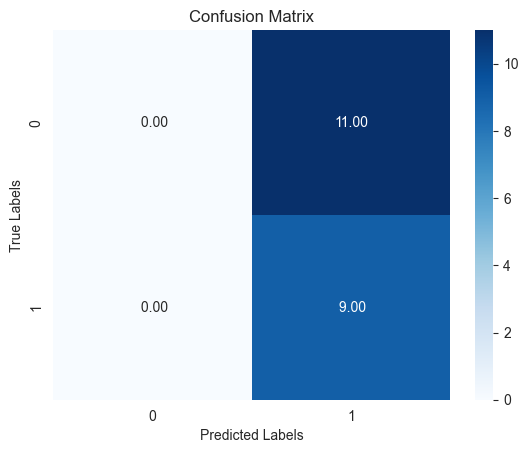

In [75]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

In [111]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.preprocessing import sequence
from keras.api.models import Sequential
from keras.api.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Flatten
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [112]:
df = pd.read_csv("../data/spotify-user-reviews.csv")
df

,review,label
0,A huge collection of music,positive
1,Downloaded music still can't be played offline...,negative
2,This app is the best music app I have ever see...,positive
3,"Works great just with the car's Bluetooth, but...",negative
4,Best music app so far,positive
...,...,...
9995,All of a sudden the app will not work on my S22+,negative
9996,THE BEST MUSIC APP EVER! I WOULD GIVE IT INFIN...,positive
9997,I used to love this app..even though it had so...,negative
9998,Great app. Wish I could add multiple tracks fr...,negative


<Axes: xlabel='label'>

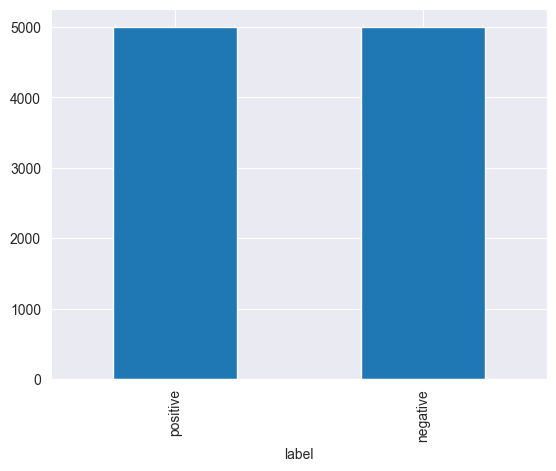

In [113]:
df["label"].value_counts().plot.bar()

In [114]:
df.isnull().sum()

review    0
label     0
dtype: int64

<Axes: ylabel='Frequency'>

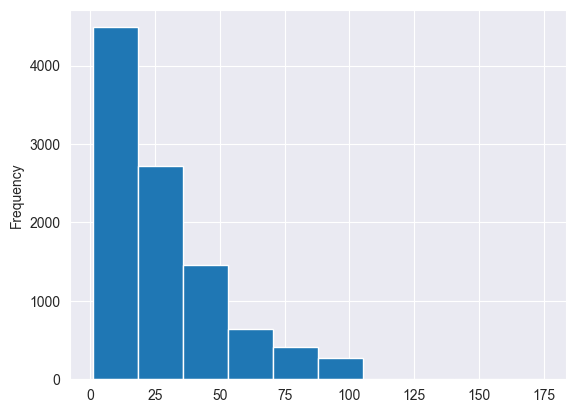

In [116]:
df["review"].str.split(" ").apply(len).plot.hist()

<Axes: >

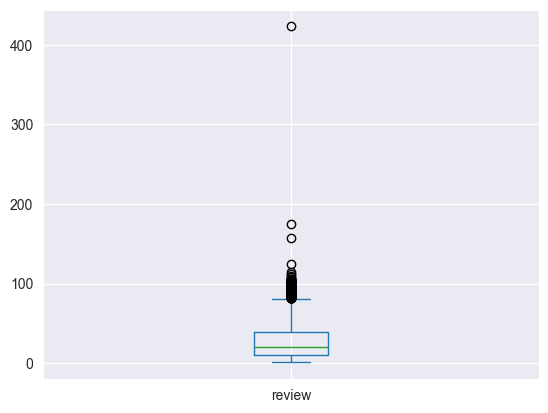

In [117]:
df["review"].str.split().apply(len).plot.box()

In [129]:
outlier_limit = 70

In [130]:
df = df[df["review"].str.split().apply(len) < outlier_limit].copy(deep=True)
df

,review,label
0,A huge collection of music,positive
1,Downloaded music still can't be played offline...,negative
2,This app is the best music app I have ever see...,positive
3,"Works great just with the car's Bluetooth, but...",negative
4,Best music app so far,positive
...,...,...
9995,All of a sudden the app will not work on my S22+,negative
9996,THE BEST MUSIC APP EVER! I WOULD GIVE IT INFIN...,positive
9997,I used to love this app..even though it had so...,negative
9998,Great app. Wish I could add multiple tracks fr...,negative


<Axes: ylabel='Frequency'>

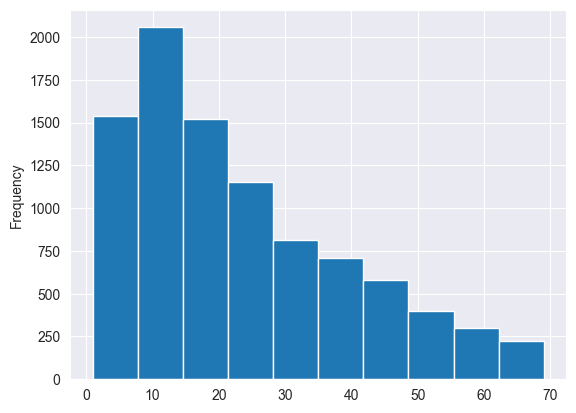

In [131]:
df["review"].str.split().apply(len).plot.hist()

<Axes: >

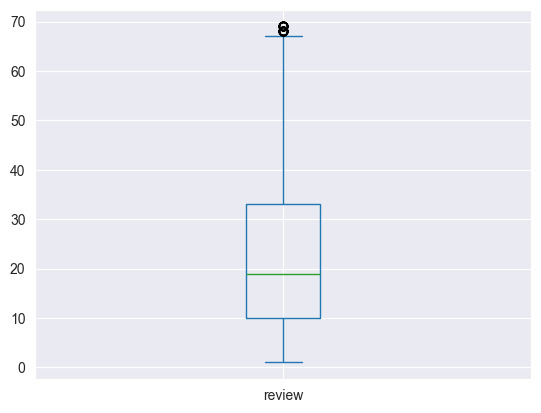

In [132]:
df["review"].str.split().apply(len).plot.box()

In [133]:
def get_vocabulary(texts: list[str]) -> list[str]:
    vocabulary = []
    for text in texts:
        for word in text.split(" "):
            vocabulary.append(word)
    return list(set(vocabulary))

In [134]:
vocabular = get_vocabulary(df["review"].tolist())

In [135]:
len(vocabular)

16506

In [137]:
max_vocabulary_size = 16000

In [179]:
X, y = df["review"], pd.get_dummies(df["label"])

In [180]:
y.head()

,negative,positive
0,False,True
1,True,False
2,False,True
3,True,False
4,False,True


In [181]:
num_classes = y.shape[1]
num_classes

2

In [182]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [183]:
tokenizer = Tokenizer(num_words=max_vocabulary_size)
tokenizer.fit_on_texts(train_X.values)
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

In [184]:
train_X

[[574,
  24,
  12,
  6,
  4,
  179,
  251,
  19,
  11,
  92,
  14,
  19,
  11,
  1155,
  75,
  7,
  1226,
  5,
  879,
  275,
  752,
  524,
  13,
  575,
  5,
  4,
  94,
  54,
  3,
  100,
  2608,
  75,
  60,
  1,
  15,
  704,
  6,
  130,
  9,
  392,
  41,
  309,
  2,
  300,
  69,
  836,
  43,
  58,
  40,
  98,
  232,
  402,
  76,
  107,
  21,
  24,
  1,
  6],
 [23],
 [1,
  175,
  163,
  1042,
  1,
  792,
  459,
  4,
  16,
  44,
  793,
  3,
  1,
  310,
  420,
  48,
  604,
  64,
  71,
  33,
  332,
  232],
 [2,
  18,
  15,
  36,
  24,
  21,
  2,
  38,
  138,
  33,
  1,
  8,
  2,
  54,
  38,
  358,
  5,
  53,
  1518,
  1867,
  359],
 [1, 123, 3, 6, 35, 2, 131, 2609, 880, 4, 2610, 753],
 [2,
  605,
  12,
  7,
  1043,
  1,
  55,
  2611,
  3536,
  74,
  1,
  2612,
  393,
  71,
  12,
  2,
  54,
  3,
  31,
  3,
  11,
  566,
  20,
  14,
  5,
  9,
  34,
  7,
  510,
  71,
  12,
  52],
 [32,
  6,
  10,
  79,
  8,
  27,
  95,
  37,
  14,
  2,
  3537,
  57,
  30,
  21,
  19,
  98,
  90,
  16,
  38,
  2

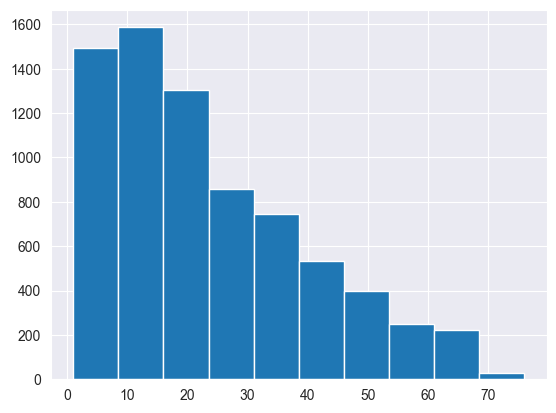

In [185]:
plt.hist([len(tokens) for tokens in train_X]);

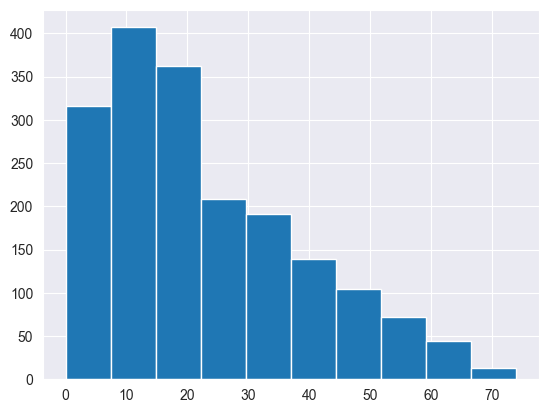

In [186]:
plt.hist([len(tokens) for tokens in test_X]);

In [187]:
maxlen = 60

In [188]:
train_X = sequence.pad_sequences(train_X, maxlen=maxlen)
test_X = sequence.pad_sequences(test_X, maxlen=maxlen)

In [189]:
train_X.shape, test_X.shape

((7424, 60), (1857, 60))

In [190]:
import  keras

In [191]:
model = Sequential([
    Embedding(input_dim=max_vocabulary_size, output_dim=128),
    Conv1D(filters=32, kernel_size=4, padding="same", activation="relu"),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=4, padding="same", activation="relu"),
    MaxPooling1D(pool_size=2),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    LSTM(64, dropout=0.1, recurrent_dropout=0.1),
    Dense(2, activation="softmax")
])

In [192]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer="adam",
    metrics=["precision", "recall", "f1_score"]
)

In [193]:
history = model.fit(train_X, train_y, validation_split=0.2, batch_size=64, epochs=2)

Epoch 1/2
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - f1_score: 0.6894 - loss: 0.5921 - precision: 0.6938 - recall: 0.6938 - val_f1_score: 0.8496 - val_loss: 0.3656 - val_precision: 0.8498 - val_recall: 0.8498
Epoch 2/2
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - f1_score: 0.8861 - loss: 0.2872 - precision: 0.8862 - recall: 0.8862 - val_f1_score: 0.8663 - val_loss: 0.3432 - val_precision: 0.8667 - val_recall: 0.8667


In [194]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 60, 128)        │     2,048,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 60, 32)         │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 30, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 15, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,663,080 (25.42 MB)

 Trainable params: 2,221,026 (8.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,442,054 (16.95 MB)

<Axes: >

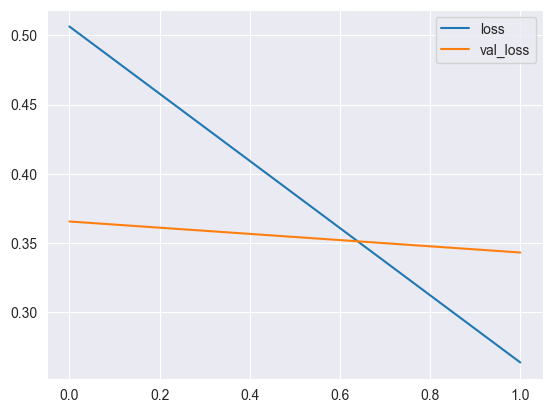

In [195]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

In [196]:
preds = model.predict(test_X)

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [197]:
test_y

,negative,positive
1281,False,True
7832,True,False
3051,False,True
2689,False,True
1621,True,False
...,...,...
8524,True,False
2480,False,True
1854,True,False
7192,True,False


In [198]:
test_y = test_y.values.argmax(axis=1)
preds = preds.argmax(axis=1)

In [199]:
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       857
           1       0.93      0.80      0.86      1000

    accuracy                           0.86      1857
   macro avg       0.86      0.86      0.86      1857
weighted avg       0.87      0.86      0.86      1857



Text(0.5, 1.0, 'Confusion Matrix')

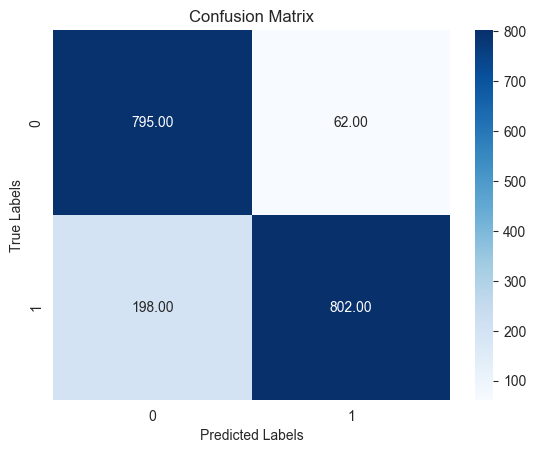

In [200]:
sns.heatmap(confusion_matrix(test_y, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.


In [ ]:
# Write your code here. Add as many boxes as you need.

## Tokenization
Tokenize the texts using the `AutoTokenizer` class.

In [ ]:
# Write your code here. Add as many boxes as you need.

## Fine-tuning a Pre-trained Language Model for Classification
Fine-tune a pre-trained language model for classification on the given dataset.

Define the model using the `AutoModelForSequenceClassification` class.

In [ ]:
# Write your code here. Add as many boxes as you need.

Define the traning parameters using the `TrainingArguments` class.

In [ ]:
# Write your code here. Add as many boxes as you need.

Define the training using the `Trainer` class.

In [ ]:
# Write your code here. Add as many boxes as you need.

Fine-tune (train) the pre-trained lanugage model.

In [ ]:
# Write your code here. Add as many boxes as you need.

Use the trained model to make predictions for the test set.

In [ ]:
# Write your code here. Add as many boxes as you need.

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [ ]:
# Write your code here. Add as many boxes as you need.

# Laboratory Exercise - Bonus Task (+ 2 points)

Implement a machine learning pipeline to classify Spotify user reviews as positive or negative. Use TF-IDF vectorization to transform the review text into numerical features, and train a logistic regression model on the transformed data. Split the dataset into training and testing sets, fit the pipeline on the training data, and evaluate its performance using metrics such as precision, recall, and F1-score. To gain insights into the most influential words or phrases associated with positive and negative reviews, analyze the coefficients from the logistic regression model trained on the TF-IDF features. Present the top keywords for each sentiment in a table or a bar chart to provide a clear understanding of the terms driving user feedback.

In [ ]:
# Write your code here. Add as many boxes as you need.